# Q-LEARNING

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
class DQN(nn.Module):
    def __init__(self, num_state_features):
        super().__init__()
         
        self.fc1 = nn.Linear(in_features=num_state_features, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)            

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

### Experience class

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [5]:
#e = Experience(2,3,1,4)
#e

### replay memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

### Epsilong greedy strategy

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)

### Agent

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device) # exploit

In [9]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.done = False
        self.current_state = None
    def reset(self):
        self.current_state = self.env.reset()

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):        
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def get_state(self):
        if self.done:
            return torch.zeros_like(
            torch.tensor(self.current_state), device=self.device
            ).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()
        
    def num_state_features(self):
        return self.env.observation_space.shape[0]


In [10]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [11]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [12]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

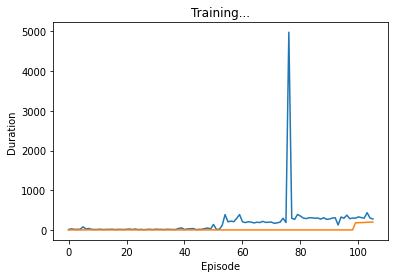

Episode 106 
 100 episode moving avg: 196.64


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN(em.num_state_features()).to(device)
target_net = DQN(em.num_state_features()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1,t2,t3,t4)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    #if get_moving_average(100, episode_durations)[-1] >= 195:
    #    break
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if get_moving_average(100, episode_durations)[-1] >= 195:
        break
em.close()